In [1]:
import numpy as np
import pandas as pd
import open3d as o3d
import os
from horizon import load, project, signal
# auto reload packages
%load_ext autoreload
%autoreload 2

/tmp/ipykernel_2333061/2351431590.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Extract viewpoints and skylines from GeoPose3k

In [2]:
datadir = '../../data/geopose3k/'
viewpoints = pd.read_csv(datadir+'infos.csv')

In [3]:
# restrict to small lat and lon ranges to compute faster (this is a test, for whole dataset split in chunks)
viewpoints = viewpoints[(viewpoints['longitude']<8) & (viewpoints['latitude']<47)]
viewpoints.head()

,id,latitude,longitude,elevation,yaw,pitch,roll,fov
1,28561570606,46.3463,6.84551,1407.0,-0.026613,0.087538,-0.013312,1.153100
6,eth_ch1_1332166_01024,46.4220,7.40200,1939.0,1.241760,-0.023776,0.036813,0.643872
9,eth_ch1_2011-10-01_17:13:12_01024,46.5562,7.90146,855.5,-2.091580,0.187911,0.049084,0.939313
10,eth_ch1_2011-10-01_17:15:04_01024,46.5561,7.90143,856.0,-3.101150,0.665497,0.029063,0.911105
11,eth_ch1_2011-10-01_17:18:26_01024,46.5561,7.90143,856.0,1.651320,0.396528,0.012251,0.939313


In [4]:
# lat lon to np array
np_viewpoints = viewpoints[['latitude', 'longitude']].to_numpy()
# extract boundaries
bounds = [np_viewpoints[:,0].min(), np_viewpoints[:,1].min(), np_viewpoints[:,0].max(), np_viewpoints[:,1].max()]
# project to EPSG:2056 (switzerland)
np_viewpoints = project.array_to_xy(np_viewpoints, epsg='2056')

In [5]:
# def get_ids_to_filter(dist_matrix, threshold):
#     args = np.argwhere((dist_matrix<threshold) & (dist_matrix!=0))[:,0]
#     args = np.unique(args)
#     return args

In [6]:
# # compute distance between each pair of points
# dist_matrix = project.distance_points_points(np_viewpoints, np_viewpoints)
# # remove points closer than 5km to another
# to_remove = get_ids_to_filter(dist_matrix, 5000)
# np_viewpoints = np.delete(np_viewpoints, to_remove, axis=0)
# print('Number of viewpoints :', len(np_viewpoints))
# # same for indexes
# indexes = viewpoints['id'].to_numpy()
# indexes = np.delete(indexes, to_remove, axis=0)

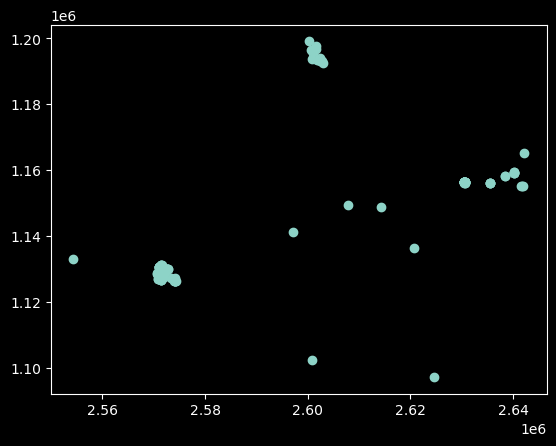

In [7]:
import matplotlib.pyplot as plt
plt.scatter(np_viewpoints[:,0], np_viewpoints[:,1])

## Download terrain data

In [8]:
terrain_data = "../../data/terrain/geopose3k/"
horizon_data = "../../data/horizon/geopose3k/"
place_name = "Alps_test"
n=5
margin_distance=50

In [9]:
bounds[:2] = load.bounds_from_distance(bounds[0], bounds[1], margin_distance)[:2]
bounds[2:] = load.bounds_from_distance(bounds[2], bounds[3], margin_distance)[2:]
bounds

[6.521457160566365, 45.8004977499775, 8.318565919855534, 47.168202250022496]

In [10]:
if not os.path.exists(terrain_data+place_name+'.xyz'):
    load.download_from_eio(terrain_data, place_name, bounds=bounds, epsg='2056')
pc = o3d.io.read_point_cloud(terrain_data+place_name+'.xyz')

In [11]:
o3d.visualization.draw_geometries([pc])

## Extract skyline for each viewpoint

In [12]:
def crop_pc(pc, view_point, distance=50_000):
    bbox = o3d.geometry.AxisAlignedBoundingBox(min_bound=(view_point[0]-distance, view_point[1]-distance, -1000), 
                                            max_bound=(view_point[0]+distance, view_point[1]+distance, 5000))
    return pc.crop(bbox)

In [13]:
def get_viewpoint_altitude(pc, view_point):
    terrain_points = np.asarray(pc.points)
    closest = project.closest_point(terrain_points[:,0:2], view_point[:2])
    view_point = np.append(view_point,  terrain_points[closest][2] + 3) # add 3m to not be at ground level
    return view_point

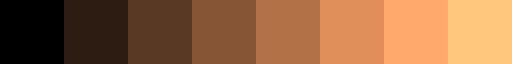

In [130]:
# colormap
plt.get_cmap('copper', 8)

In [ ]:
# for each viewpoint
for i, index in enumerate(viewpoints['id']):
    # get the viewpoint (2D) coordinates and id
    name = str(index)
    view_point = np_viewpoints[i]
    # download and process data if unknown
    if not os.path.exists(horizon_data+name+'.npy'):
        # crop terrain data
        cropped_pc = crop_pc(pc, view_point)
        # get view point altitude
        view_point = get_viewpoint_altitude(cropped_pc, view_point)
        # extract skyline
        spherical = project.array_cartesian_to_spherical(cropped_pc.points, view_point)
        angles = project.get_deg_angles(spherical)
        skyline = project.get_skyline(angles, savepath=horizon_data+name)
        depths = project.skyline_depth(spherical, angles, skyline, savepath=horizon_data+name+'_depth')
    # otherwise, load directly from files
    else:
        skyline = np.load(horizon_data+name+'.npy').astype(float)
        depths = np.load(horizon_data+name+'_depth'+'.npy').astype(float)

    # display skyline
    smooth_skyline = signal.smooth_with_depth(skyline, depths)
    signal.plot_skyline(smooth_skyline, 'Skyline '+name)
    #signal.plot_skyline(smooth_skyline, 'Skyline '+name, depths=depths)